In [1]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [2]:
#Import Statements
import os
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from numpy import array
import joblib
import sys

Using TensorFlow backend.


In [3]:
#Change plot settings
plt.rcParams['axes.linewidth'] = 2
plt.rcParams['font.size'] = 15
plt.rcParams['xtick.major.size'] = 10
plt.rcParams['xtick.major.width'] = 2
plt.rcParams['ytick.major.size'] = 10
plt.rcParams['ytick.major.width'] = 2

In [4]:
#Change the directory to the working directory for the project
os.chdir('/content/drive/My Drive/New LSTM Crack')

# Functions

In [5]:
def read_file(file_name):
  file = file_name
  return pd.read_csv(file)

In [6]:
def create_prediction_data(prediction_data):
  data_array = np.asarray(prediction_data)
  
  temp_data = data_array[:, 0]
  temp_series = (temp_data / 900).reshape(len(data_array), 1)
  #temp_series = (temp_data / np.amax(temp_data)).reshape(len(data_array), 1)

  stress_intensity = Scaler.transform(data_array[:, 1].reshape(len(data_array), 1))

  return np.hstack((temp_series, stress_intensity))

In [7]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X = list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x = sequences[i:end_ix, :]
		X.append(seq_x)
	return array(X)

In [8]:
def create_actual_data(file_name):
  file = pd.read_csv(file_name)
  data_array = np.asarray(file)
  crack_length = data_array[:, 1]
  return crack_length

In [9]:
def create_da_dk_intermediate(case, stress_intensity, change):
  da = []
  dk = []
  
  for i in range(len(case) - change):
    da.append(case[i + change] - case[i])

  for i in range(len(stress_intensity) - change):
    dk.append(stress_intensity[i + change] - stress_intensity[i])

  return np.log(np.asarray(da)), np.log(np.asarray(dk))

In [10]:
def create_da_dk_actual(filename, crack_length, change):
  file = pd.read_csv(filename)
  data_array = np.asarray(file)

  stress_intensity = data_array[:, 1].reshape(len(data_array), 1)
  stress_intensity = Scaler.transform(stress_intensity)

  da = []
  dk = []

  for i in range(len(crack_length) - change):
    da.append(crack_length[i + change] - crack_length[i])

  for i in range(len(stress_intensity) - change):
    dk.append(stress_intensity[i + change] - stress_intensity[i])

  return np.log(np.asarray(da)), np.log(np.asarray(dk))

In [20]:
def data_offset(predicted, original):
  predict = predicted.flatten()
  minimum = min(len(original), len(predict))
  difference = np.subtract(original[:minimum], predict[:minimum])
  average_offset = np.average(difference)
  offset_data = predict + average_offset
  return offset_data

# Loading Data

In [12]:
#Load previously trained model
model = keras.models.load_model("./Weights/Model_HT_3step900Scale100000")
print("Model Loaded")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model Loaded


In [13]:
data_1600_150 = read_file('./Predict/HeatTreated/t150_4-15-21_R05_1600N.csv')
data_1700_150 = read_file('./Predict/HeatTreated/t150_4-13-21_R05_1700N.csv')
data_1800_150 = read_file('./Predict/HeatTreated/t150_4-12-21_R05_1800N.csv')

data_1600_250 = read_file('./Predict/HeatTreated/t250_4-8-21_R05_1600N.csv')
data_1700_250 = read_file('./Predict/HeatTreated/t250_4-7-21_R05_1700N.csv')
data_1800_250 = read_file('./Predict/HeatTreated/t250_4-21-21_R05_1800N.csv')

data_1600_35 = read_file('./Predict/HeatTreated/t35_4-3-21_R05_1600N.csv')
data_1700_35 = read_file('./Predict/HeatTreated/t35_4-2-21_R05_1700N.csv')
data_1800_35 = read_file('./Predict/HeatTreated/t35_4-19-21_R05_1800N.csv')

data_1600_573 = read_file('./Predict/HeatTreated/1600N_HT_573K.csv')
data_1700_573 = read_file('./Predict/HeatTreated/1700N_HT_573K.csv')
data_1800_573 = read_file('./Predict/HeatTreated/1800N_HT_573K.csv')


print('Data Loaded')

Data Loaded


In [14]:
Scaler = joblib.load('./Weights/Scaler_HT.save')

# Create Prediction Data

In [15]:
pred_1600_150 = create_prediction_data(data_1600_150)
pred_1700_150 = create_prediction_data(data_1700_150)
pred_1800_150 = create_prediction_data(data_1800_150)

pred_1600_250 = create_prediction_data(data_1600_250)
pred_1700_250 = create_prediction_data(data_1700_250)
pred_1800_250 = create_prediction_data(data_1800_250)

pred_1600_35 = create_prediction_data(data_1600_35)
pred_1700_35 = create_prediction_data(data_1700_35)
pred_1800_35 = create_prediction_data(data_1800_35)

pred_1600_573 = create_prediction_data(data_1600_573)
pred_1700_573 = create_prediction_data(data_1700_573)
pred_1800_573 = create_prediction_data(data_1800_573)

In [16]:
print(pred_1800_573)

[[6.36666667e-01 1.29764880e-03]
 [6.36666667e-01 1.57971058e-03]
 [6.36666667e-01 1.82094653e-03]
 ...
 [6.36666667e-01 3.29370215e+00]
 [6.36666667e-01 3.31146835e+00]
 [6.36666667e-01 3.33312365e+00]]


In [17]:
n_steps = 3
split_1600_150 = split_sequences(pred_1600_150, n_steps)
split_1700_150 = split_sequences(pred_1700_150, n_steps)
split_1800_150 = split_sequences(pred_1800_150, n_steps)

split_1600_250 = split_sequences(pred_1600_250, n_steps)
split_1700_250 = split_sequences(pred_1700_250, n_steps)
split_1800_250 = split_sequences(pred_1800_250, n_steps)

split_1600_35 = split_sequences(pred_1600_35, n_steps)
split_1700_35 = split_sequences(pred_1700_35, n_steps)
split_1800_35 = split_sequences(pred_1800_35, n_steps)

split_1600_573 = split_sequences(pred_1600_573, n_steps)
split_1700_573 = split_sequences(pred_1700_573, n_steps)
split_1800_573 = split_sequences(pred_1800_573, n_steps)

# Predict On Data

In [18]:
yhat1600_35 = model.predict(split_1600_35, verbose=1)
yhat1700_35 = model.predict(split_1700_35, verbose=1)
yhat1800_35 = model.predict(split_1800_35, verbose=1)
print('35K FINISHED')

yhat1600_150 = model.predict(split_1600_150, verbose=1)
yhat1700_150 = model.predict(split_1700_150, verbose=1)
yhat1800_150 = model.predict(split_1800_150, verbose=1)
print('150K FINISHED')

yhat1600_250 = model.predict(split_1600_250, verbose=1)
yhat1700_250 = model.predict(split_1700_250, verbose=1)
yhat1800_250 = model.predict(split_1800_250, verbose=1)
print('250K FINISHED')

yhat1600_573 = model.predict(split_1600_573, verbose=1)
yhat1700_573 = model.predict(split_1700_573, verbose=1)
yhat1800_573 = model.predict(split_1800_573, verbose=1)
print('573K FINISHED')

178570/178570 [==============================] - 30s 169us/step
35K FINISHED
183685/183685 [==============================] - 31s 171us/step
150K FINISHED
122797/122797 [==============================] - 21s 169us/step
250K FINISHED
122797/122797 [==============================] - 21s 169us/step
573K FINISHED


# Plotting With Actual Data

In [19]:
cl1600_150 = create_actual_data('./Test/HeatTreated/t150_4-15-21_R05_1600N_testing.csv')
cl1700_150 = create_actual_data('./Test/HeatTreated/t150_4-13-21_R05_1700N_testing.csv')
cl1800_150 = create_actual_data('./Test/HeatTreated/t150_4-12-21_R05_1800N_testing.csv')

cl1600_250 = create_actual_data('./Test/HeatTreated/t250_4-8-21_R05_1600N_testing.csv')
cl1700_250 = create_actual_data('./Test/HeatTreated/t250_4-7-21_R05_1700N_testing.csv')
cl1800_250 = create_actual_data('./Test/HeatTreated/t250_4-21-21_R05_1800N_testing.csv')

cl1600_35 = create_actual_data('./Test/HeatTreated/t35_4-3-21_R05_1600N_testing.csv')
cl1700_35 = create_actual_data('./Test/HeatTreated/t35_4-2-21_R05_1700N_testing.csv')
cl1800_35 = create_actual_data('./Test/HeatTreated/t35_4-19-21_R05_1800N_testing.csv')

cl1600_573 = create_actual_data('./Test/HeatTreated/1600N_HT_573K.csv')
cl1700_573 = create_actual_data('./Test/HeatTreated/1700N_HT_573K.csv')
cl1800_573 = create_actual_data('./Test/HeatTreated/1800N_HT_573K.csv')

In [21]:
yhat1600_35 = data_offset(yhat1600_35, cl1600_35)
yhat1700_35 = data_offset(yhat1700_35, cl1700_35)
yhat1800_35 = data_offset(yhat1800_35, cl1800_35)

yhat1600_150 = data_offset(yhat1600_150, cl1600_150)
yhat1700_150 = data_offset(yhat1700_150, cl1700_150)
yhat1800_150 = data_offset(yhat1800_150, cl1800_150)

yhat1600_250 = data_offset(yhat1600_250, cl1600_250)
yhat1700_250 = data_offset(yhat1700_250, cl1700_250)
yhat1800_250 = data_offset(yhat1800_250, cl1800_250)

yhat1600_573 = data_offset(yhat1600_573, cl1600_573)
yhat1700_573 = data_offset(yhat1700_573, cl1700_573)
yhat1800_573 = data_offset(yhat1800_573, cl1800_573)

Paper Figure

Text(500, 340, 'C)')

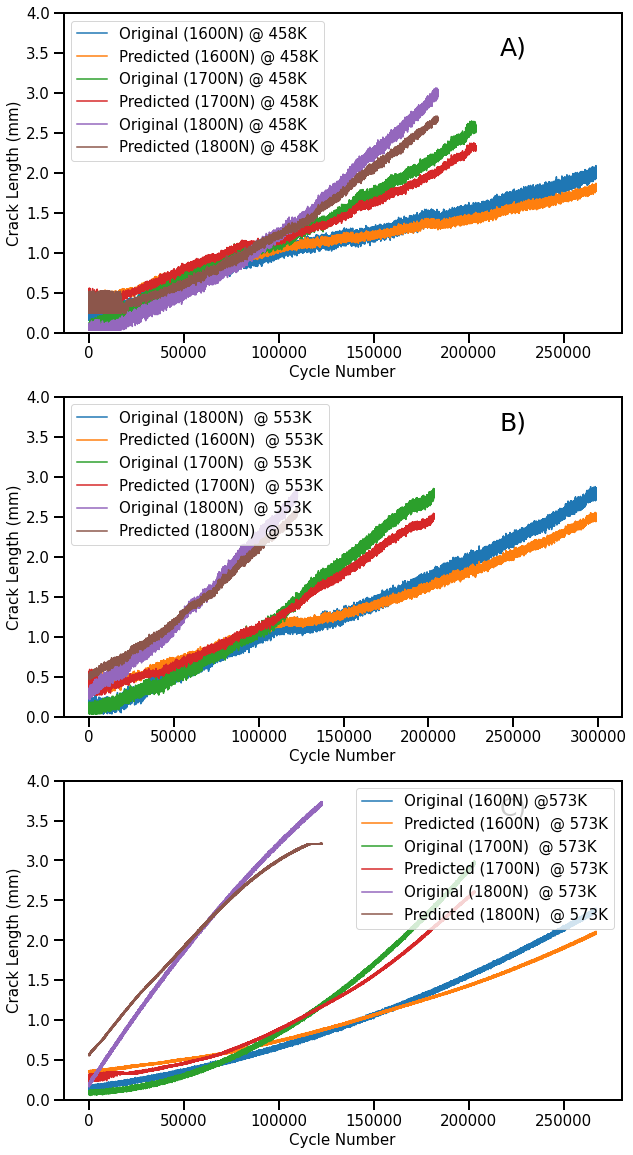

In [22]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(10,20))

#458K Data
ax1.plot(cl1600_150, label = 'Original (1600N) @ 458K')
ax1.plot(yhat1600_150, label = 'Predicted (1600N) @ 458K')
ax1.plot(cl1700_150, label = 'Original (1700N) @ 458K')
ax1.plot(yhat1700_150, label = 'Predicted (1700N) @ 458K')
ax1.plot(cl1800_150, label = 'Original (1800N) @ 458K')
ax1.plot(yhat1800_150, label = 'Predicted (1800N) @ 458K')
ax1.set_xlabel("Cycle Number")
ax1.set_ylabel("Crack Length (mm)")
ax1.set_ylim([0, 4])
ax1.legend(loc=2)
ax1.annotate('A)',xy=(500, 1100), xycoords='figure points', fontsize=25, color='Black')

#553K Data
ax2.plot(cl1600_250, label = 'Original (1800N)  @ 553K')
ax2.plot(yhat1600_250, label = 'Predicted (1600N)  @ 553K')
ax2.plot(cl1700_250, label = 'Original (1700N)  @ 553K')
ax2.plot(yhat1700_250, label = 'Predicted (1700N)  @ 553K')
ax2.plot(cl1800_250, label = 'Original (1800N)  @ 553K')
ax2.plot(yhat1800_250, label = 'Predicted (1800N)  @ 553K')
ax2.set_xlabel("Cycle Number")
ax2.set_ylabel("Crack Length (mm)")
ax2.legend()
ax2.set_ylim([0, 4])
ax2.annotate('B)',xy=(500, 725), xycoords='figure points', fontsize=25, color='Black')


#308K Data
ax3.plot(cl1600_573, label = 'Original (1600N) @573K')
ax3.plot(yhat1600_573, label = 'Predicted (1600N)  @ 573K')
ax3.plot(cl1700_573, label = 'Original (1700N)  @ 573K')
ax3.plot(yhat1700_573, label = 'Predicted (1700N)  @ 573K')
ax3.plot(cl1800_573, label = 'Original (1800N)  @ 573K')
ax3.plot(yhat1800_573, label = 'Predicted (1800N)  @ 573K')
ax3.set_xlabel('Cycle Number')
ax3.set_ylabel('Crack Length (mm)')
ax3.legend()
ax3.set_ylim([0, 4])
ax3.annotate('C)',xy=(500, 340), xycoords='figure points', fontsize=25, color='Black')

#plt.savefig('./Paper Images/CrackLength_HT.pdf', format='pdf',bbox_inches='tight')

Heatmap

In [73]:
force_heatmap_308 = np.hstack((np.repeat(1600,len(yhat1600_35)).reshape(len(yhat1600_35),1),
                           np.repeat(1700,len(yhat1600_35)).reshape(len(yhat1600_35),1),
                           np.repeat(1800,len(yhat1600_35)).reshape(len(yhat1600_35),1)))

heatmap_len_308 = min(len(yhat1600_35),len(yhat1700_35),len(yhat1800_35))

crack_heatmap_308 = np.hstack((yhat1600_35[:heatmap_len_308].reshape(heatmap_len_308,1),yhat1700_35[:heatmap_len_308].reshape(heatmap_len_308,1),yhat1800_35[:heatmap_len_308].reshape(heatmap_len_308,1)))

arr_ti_308 = np.arange(0,heatmap_len_308).reshape(heatmap_len_308,1)
time_heatmap_308 = np.hstack((arr_ti_308,arr_ti_308,arr_ti_308))

In [75]:
force_heatmap_553 = np.hstack((np.repeat(1600,len(yhat1600_35)).reshape(len(yhat1600_35),1),
                           np.repeat(1700,len(yhat1600_35)).reshape(len(yhat1600_35),1),
                           np.repeat(1800,len(yhat1600_35)).reshape(len(yhat1600_35),1)))

heatmap_len_553 = min(len(yhat1600_250),len(yhat1700_250),len(yhat1800_250))

crack_heatmap_553 = np.hstack((yhat1600_250[:heatmap_len_553].reshape(heatmap_len_553,1),yhat1700_250[:heatmap_len_553].reshape(heatmap_len_553,1),yhat1800_250[:heatmap_len_553].reshape(heatmap_len_553,1)))

arr_ti_553 = np.arange(0,heatmap_len_553).reshape(heatmap_len_553,1)
time_heatmap_553 = np.hstack((arr_ti_553,arr_ti_553,arr_ti_553))

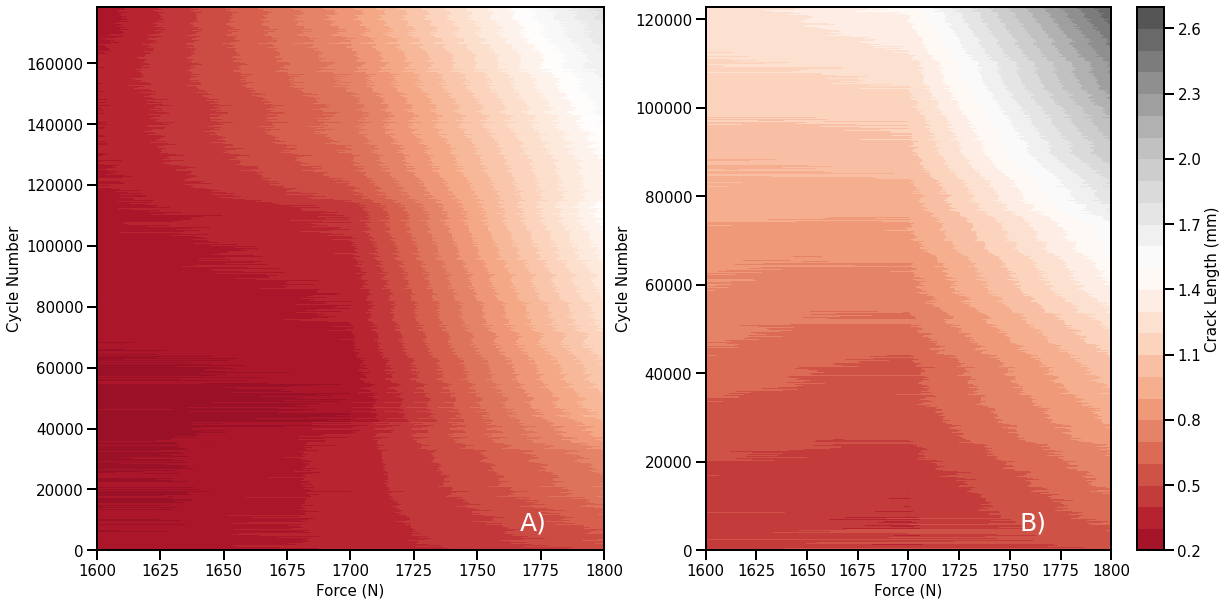

In [78]:
opts = {'vmin': 0, 'vmax': 3, 'cmap': 'RdGy', 'levels':23}
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))

plot1 = ax1.contourf(force_heatmap_308[:heatmap_len_308,:],time_heatmap_308, crack_heatmap_308, **opts)
ax1.set_xlabel("Force (N)")
ax1.set_ylabel("Cycle Number")
ax1.annotate('A)',xy=(520, 75), xycoords='figure points', fontsize=25, color='white')

plot2 = ax2.contourf(force_heatmap_553[:heatmap_len_553,:],time_heatmap_553,crack_heatmap_553, **opts)
ax2.set_xlabel("Force (N)")
ax2.set_ylabel("Cycle Number")
ax2.annotate('B)',xy=(1020, 75), xycoords='figure points', fontsize=25, color='white')

cbar = fig.colorbar(plot2, ax=ax2)
cbar.set_label('Crack Length (mm)')

#plt.savefig('./Paper Images/Heatmap_HT.pdf', format='pdf',bbox_inches='tight')

DaDn

In [79]:
change = 10000

da1600_250, dk1600_250 = create_da_dk_intermediate(yhat1600_250, pred_1600_250[:, 1], change)
da1700_250, dk1700_250 = create_da_dk_intermediate(yhat1700_250, pred_1700_250[:, 1], change)
da1800_250, dk1800_250 = create_da_dk_intermediate(yhat1800_250, pred_1800_250[:, 1], change)

da1600_150, dk1600_150 = create_da_dk_intermediate(yhat1600_150, pred_1600_150[:, 1], change)
da1700_150, dk1700_150 = create_da_dk_intermediate(yhat1700_150, pred_1700_150[:, 1], change)
da1800_150, dk1800_150 = create_da_dk_intermediate(yhat1800_150, pred_1800_150[:, 1], change)

da1600_35, dk1600_35 = create_da_dk_intermediate(yhat1600_35, pred_1600_35[:, 1], change)
da1700_35, dk1700_35 = create_da_dk_intermediate(yhat1700_35, pred_1700_35[:, 1], change)
da1800_35, dk1800_35 = create_da_dk_intermediate(yhat1800_35, pred_1800_35[:, 1], change)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in log
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in log
  # This is added back by InteractiveShellApp.init_path()


In [80]:
da1600_250_ts = da1600_250[0::1890]
da1700_250_ts = da1700_250[0::1890]
da1800_250_ts = da1800_250[0::1890]
dk1600_250_ts = dk1600_250[0::1890]
dk1700_250_ts = dk1700_250[0::1890]
dk1800_250_ts = dk1800_250[0::1890]

da1600_150_ts = da1600_150[0::1890]
da1700_150_ts = da1700_150[0::1890]
da1800_150_ts = da1800_150[0::1890]
dk1600_150_ts = dk1600_150[0::1890]
dk1700_150_ts = dk1700_150[0::1890]
dk1800_150_ts = dk1800_150[0::1890]

da1600_35_ts = da1600_35[0::1890]
da1700_35_ts = da1700_35[0::1890]
da1800_35_ts = da1800_35[0::1890]
dk1600_35_ts = dk1600_35[0::1890]
dk1700_35_ts = dk1700_35[0::1890]
dk1800_35_ts = dk1800_35[0::1890]

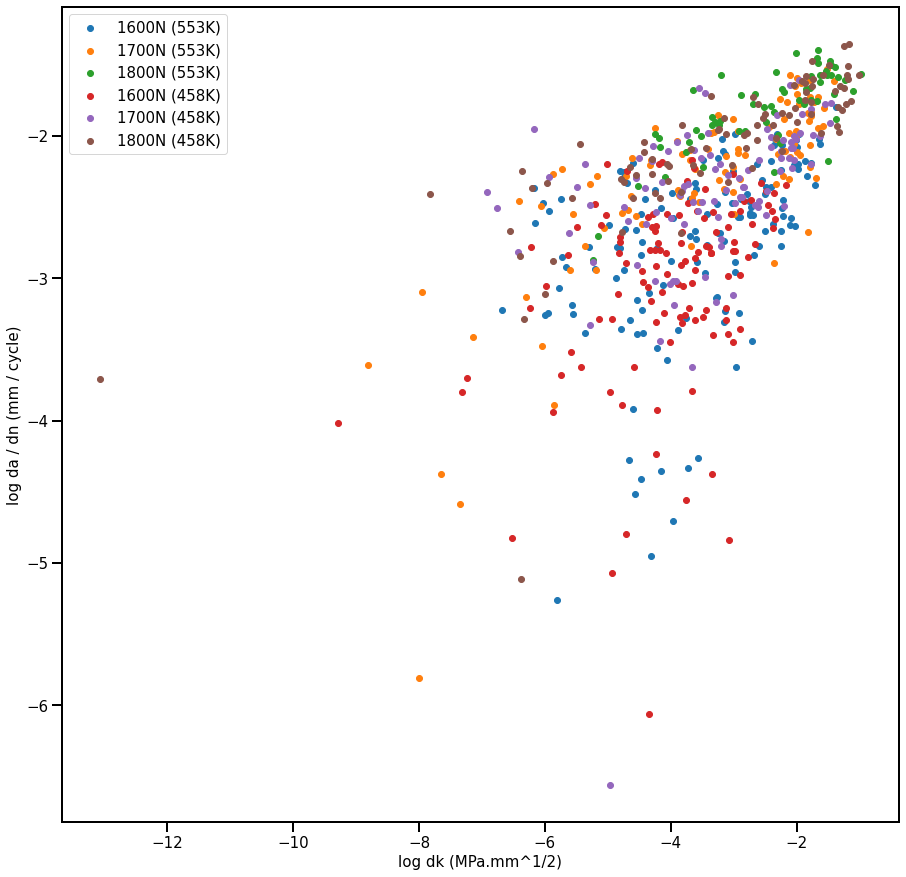

In [82]:
plt.figure(figsize=(15,15))

plt.scatter(dk1600_250_ts[:da1600_250_ts.shape[0]], da1600_250_ts, label = '1600N (553K)')
plt.scatter(dk1700_250_ts[:da1700_250_ts.shape[0]], da1700_250_ts, label = '1700N (553K)')
plt.scatter(dk1800_250_ts[:da1800_250_ts.shape[0]], da1800_250_ts, label = '1800N (553K)')

plt.scatter(dk1600_150_ts[:da1600_150_ts.shape[0]], da1600_150_ts, label = '1600N (458K)')
plt.scatter(dk1700_150_ts[:da1700_150_ts.shape[0]], da1700_150_ts, label = '1700N (458K)')
plt.scatter(dk1800_150_ts[:da1800_150_ts.shape[0]], da1800_150_ts, label = '1800N (458K)')

plt.xlabel('log dk (MPa.mm^1/2)')
plt.ylabel('log da / dn (mm / cycle)')
plt.legend()
#plt.savefig('./Paper Images/dadn_HT.pdf', format='pdf',bbox_inches='tight')